In [1]:
import os, random, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow version:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())


SEED = 42
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
DATA_ROOT = "/kaggle/input/brain-tumor-mri-classification"
TRAIN_DIR = os.path.join(DATA_ROOT, "Training", "Training")
TEST_DIR  = os.path.join(DATA_ROOT, "Testing", "Testing")
AUTOTUNE = tf.data.AUTOTUNE

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")
    print("Mixed precision:", mixed_precision.global_policy())
except Exception as e:
    print("Mixed precision not enabled:", e)


2025-11-10 21:18:32.827392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762809513.039178      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762809513.099747      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow version: 2.18.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mixed precision: <DTypePolicy "mixed_float16">


In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=SEED
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

preprocess = tf.keras.applications.resnet50.preprocess_input

data_augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="augment")

def preprocess_map(img, label):
    return preprocess(tf.cast(img, tf.float32)), label

train_ds = train_ds.map(lambda x, y: (data_augment(x), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(preprocess_map).cache().prefetch(AUTOTUNE)
val_ds   = val_ds.map(preprocess_map).cache().prefetch(AUTOTUNE)
test_ds  = test_ds.map(preprocess_map).prefetch(AUTOTUNE)


Found 32080 files belonging to 4 classes.
Using 25664 files for training.


I0000 00:00:1762809543.190061      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 32080 files belonging to 4 classes.
Using 6416 files for validation.
Found 8020 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = data_augment(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)

model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 224, 224,  │          0 │ add[0][0]         │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augment             │ (None, 224, 224,  │          0 │ cast_1[0][0]      │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ augment[0][0]     │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_2 (Cast)       │ (None, 2048)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │      8,196 │ cast_2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [4]:
checkpoint_path = "/kaggle/working/resnet50_braintumor_best.keras"

callbacks = [

    keras.callbacks.ModelCheckpoint(
        checkpoint_path, monitor="val_accuracy",
        save_best_only=True, verbose=1
    ),

    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=5,
        restore_best_weights=True, verbose=1
    ),

    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=2,
        min_lr=1e-7, verbose=1
    ),

    keras.callbacks.CSVLogger("/kaggle/working/train_log_phase1.csv", append=False)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/30


I0000 00:00:1762809569.675429      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7188 - loss: 0.7336
Epoch 1: val_accuracy improved from -inf to 0.84632, saving model to /kaggle/working/resnet50_braintumor_best.keras
802/802 ━━━━━━━━━━━━━━━━━━━━ 194s 227ms/step - accuracy: 0.7189 - loss: 0.7333 - val_accuracy: 0.8463 - val_loss: 0.3974 - learning_rate: 0.0010
Epoch 2/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8435 - loss: 0.4134
Epoch 2: val_accuracy did not improve from 0.84632
802/802 ━━━━━━━━━━━━━━━━━━━━ 100s 105ms/step - accuracy: 0.8435 - loss: 0.4133 - val_accuracy: 0.8454 - val_loss: 0.4206 - learning_rate: 0.0010
Epoch 3/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8551 - loss: 0.3880
Epoch 3: val_accuracy improved from 0.84632 to 0.86502, saving model to /kaggle/working/resnet50_braintumor_best.keras
802/802 ━━━━━━━━━━━━━━━━━━━━ 85s 106ms/step - accuracy: 0.8551 - loss: 0.3880 - val_accuracy: 0.8650 - val_loss: 0.3611 - learning_rate: 0.0010
Epoch 4/30
802/802 ━━━━━━━━━━

In [5]:
unfreeze_from = 140
for layer in base_model.layers[:unfreeze_from]:
    layer.trainable = False
for layer in base_model.layers[unfreeze_from:]:
    layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

ft_callbacks = [
    keras.callbacks.ModelCheckpoint(
        checkpoint_path, monitor="val_accuracy",
        save_best_only=True, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=5,
        restore_best_weights=True, verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=2,
        min_lr=1e-7, verbose=1
    ),
    keras.callbacks.CSVLogger("/kaggle/working/train_log_phase2.csv", append=True)
]

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=ft_callbacks
)


Epoch 1/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8294 - loss: 0.6020
Epoch 1: val_accuracy improved from -inf to 0.91178, saving model to /kaggle/working/resnet50_braintumor_best.keras
802/802 ━━━━━━━━━━━━━━━━━━━━ 131s 144ms/step - accuracy: 0.8294 - loss: 0.6018 - val_accuracy: 0.9118 - val_loss: 0.2743 - learning_rate: 1.0000e-05
Epoch 2/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9090 - loss: 0.2577
Epoch 2: val_accuracy improved from 0.91178 to 0.92378, saving model to /kaggle/working/resnet50_braintumor_best.keras
802/802 ━━━━━━━━━━━━━━━━━━━━ 113s 140ms/step - accuracy: 0.9090 - loss: 0.2576 - val_accuracy: 0.9238 - val_loss: 0.2414 - learning_rate: 1.0000e-05
Epoch 3/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9350 - loss: 0.1832
Epoch 3: val_accuracy improved from 0.92378 to 0.92830, saving model to /kaggle/working/resnet50_braintumor_best.keras
802/802 ━━━━━━━━━━━━━━━━━━━━ 113s 140ms/step - accuracy: 0.9350 - loss: 0.1832 - val

251/251 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step

Classification report:

              precision    recall  f1-score   support

      glioma     0.9933    0.9390    0.9654      1886
  meningioma     0.9662    0.8968    0.9302      1879
     notumor     0.9876    1.0000    0.9938      2317
   pituitary     0.8985    0.9954    0.9444      1938

    accuracy                         0.9603      8020
   macro avg     0.9614    0.9578    0.9584      8020
weighted avg     0.9624    0.9603    0.9603      8020



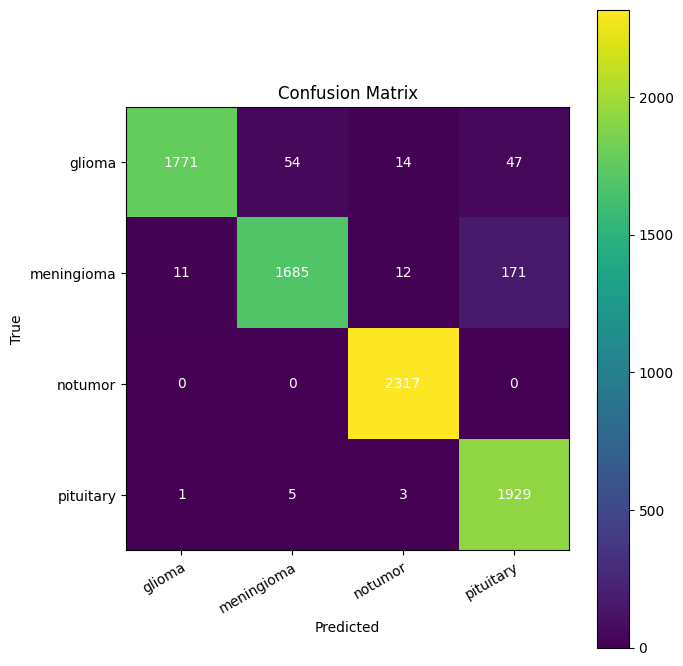

In [6]:
best_model = keras.models.load_model("/kaggle/working/resnet50_braintumor_best.keras")


y_true = []
for _, y in test_ds.unbatch():
    y_true.append(int(y.numpy()))
y_true = np.array(y_true)

y_prob = best_model.predict(test_ds, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.viridis)
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel='True',
    xlabel='Predicted',
    title='Confusion Matrix'
)
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white")

plt.tight_layout()
plt.show()
